# Prédiction de Frais Médicaux

### Importations

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### Chargement du dataset

In [7]:
df_insurance = pd.read_csv("insurance.csv", sep=",")

In [9]:
def binary_encoder(df, colonne, choix_true, choix_false):
    '''
    Encode une variable binaire

    Parameters:
        - df: le DataFrame sur lequel travailler
        - colonne: la variable à encoder
        - choix_true: la valeur à remplacer par 1
        - choix_false: la valeur à remplacer par 0
    '''
    df[colonne] = df[colonne].map({choix_false: 0, choix_true: 1})

In [10]:
def onehot_encoder(df, colonne):
    '''
    Effectue un encodage One-Hot sur une variable, puis supprime la variable originelle dans
    le DataFrame d'origine

    Parameters:
        - df: le DataFrame sur lequel travailler
        - colonne: la variable à encoder
    '''
    encoder = OneHotEncoder()
    encoded_array = encoder.fit_transform(df[[colonne]]).toarray()
    df_encoded = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out([colonne]))

    # Remplacement de la variable par le nouveau DataFrame encodé dans la DataFrame original
    df.drop(columns=[colonne], inplace=True)
    df = pd.concat([df, df_encoded], axis=1)
    return df

## Preprocessing

### Gestion des NaN

Il n'y a pas de NaN dans ce DataFrame

### Gestion des outliers

Variables ayant des outliers :
- bmi : quelques outliers, mais qui restent cohérents avec la variable et le contexte, donc pas de nécessité de traitement.
- expenses : présence de valeurs extrêmes, mais qui restent cohérents avec la variable et le contexte, donc pas de nécessité de traitement.

### Suppression des variables inutiles

Il n'y a pas de variables inutiles dans ce DataFrame

### Encodage des variables catégorielles

Les variables catégorielles sont :
- sex : variable binaire
- smoker : variable binaire
- region : variable non-ordonnée

In [11]:
# Encodage binaire sur toutes les variables binaires
binary_encoder(df=df_insurance, colonne='sex', choix_true='female', choix_false='male')
binary_encoder(df=df_insurance, colonne='smoker', choix_true='yes', choix_false='no')

In [12]:
# Encodage One-Hot pour les variables non-ordonnées
df_encoded = onehot_encoder(df=df_insurance, colonne='region')

### Dernière vérification des données

In [13]:
display(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   int64  
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   int64  
 5   charges           1338 non-null   float64
 6   region_northeast  1338 non-null   float64
 7   region_northwest  1338 non-null   float64
 8   region_southeast  1338 non-null   float64
 9   region_southwest  1338 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 104.7 KB


None

### Séparation des données d'entraînement et des données de test

In [14]:
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [15]:
display(X.head())
display(X.info())

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,0.0,0.0,0.0,1.0
1,18,0,33.770,1,0,0.0,0.0,1.0,0.0
2,28,0,33.000,3,0,0.0,0.0,1.0,0.0
3,33,0,22.705,0,0,0.0,1.0,0.0,0.0
4,32,0,28.880,0,0,0.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   int64  
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   int64  
 5   region_northeast  1338 non-null   float64
 6   region_northwest  1338 non-null   float64
 7   region_southeast  1338 non-null   float64
 8   region_southwest  1338 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 94.2 KB


None

In [16]:
display(y.head())
display(y.info())

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

<class 'pandas.core.series.Series'>
RangeIndex: 1338 entries, 0 to 1337
Series name: charges
Non-Null Count  Dtype  
--------------  -----  
1338 non-null   float64
dtypes: float64(1)
memory usage: 10.6 KB


None

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling

Etant donné qu'il n'y a qu'une seule variable dont la distribution est gaussienne dans le DataFrame, il est préférable d'utiliser le MinMaxScaler.

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

## 3. Entraînement des modèles

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer, precision_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

### Optimisation des hyperparamètres

In [16]:
# GridSearchCV
def grid_search_cv(model, param_grid):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train_scaled)

    print("Meilleurs paramètres:", grid_search.best_params_)
    print("Meilleure Cross-Validation R²:", grid_search.best_score_)

In [17]:
# RandomizeSearchCV
def randomized_search_cv(model, param_dist):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        scoring='r2',
        cv=5,
        n_jobs=-1
    )

    random_search.fit(X_train_scaled, y_train_scaled)

    print("Meilleurs paramètres:", random_search.best_params_)
    print("Meilleure Cross-Validation R²:", random_search.best_score_)

### Cross-Validation

In [18]:
# k-fold cross-validation à 5 folds
def kfold_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=kf, scoring='r2')
    print(f"k-fold cross-validation R²: {scores.mean()}")

In [19]:
# Stratified k-fold cross-validation à 5 folds
def s_kf_cv(model):
    y_binned = pd.qcut(y_train_scaled, q=5, labels=False)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=skf.split(X_train_scaled, y_binned), scoring='r2')
    print(f"stratified k-fold cross-validation R²: {scores.mean()}")

### Simple Validation

In [20]:
def performances_model(model):
    '''
    Affichage des performances du modèle passé en paramètre

    Parameters:
        model: le modèle de ML entraîné à tester
    '''
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test_scaled, y_pred)
    mae = mean_absolute_error(y_test_scaled, y_pred)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = root_mean_squared_error(y_test_scaled, y_pred)

    print(f"R² score: {r2}")
    print(f"Mean Absolute Error score: \n{mae}")
    print(f"Mean Squared Error score: \n{mse}")
    print(f"Root Mean Squared Error score: \n{rmse}")

    return r2, mae, mse, rmse

### Paramètres

In [21]:
# Dictionnaire de paramètres pour les grid search et randomized search

param = {
    'knn': {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'svm': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'epsilon': [0.001, 0.01, 0.1, 1, 10]
    },
    'decision_tree': {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['squared_error', 'absolute_error', 'poisson']
    },
    'random_forest': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    'gradient_boosting': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    'hist_gradient_boosting': {
        'max_iter': [100, 200, 500, 1000],
        'max_depth': [3, 5, 10, None],
        'min_samples_leaf': [10, 20, 50, 100, 200]
    }
}

### KNN

In [22]:
'''
Paramètres clés de KNeighborsRegressor :
    - n_neighbors: utiliser des nombres impaires pour éviter les égalités (3, 5, 7, ...)
    - weights:
        - uniform: tous les voisins contribuent de manière égale
        - distance: les voisins les plus proches contribuent plus que les plus éloignés
    - metrics:
        - euclidean: distance standard en ligne droite
        - manhattan: some des différences absolues (bien pour les données sous forme de grilles)
        - minkowski: métrique de distance généralisée où l'on peut spécifier la p-norm
'''

def knn_search_cv():
    '''
    Effectue des grid search et des randomized search sur des modèles KNN pour déterminer
    les meilleurs hyperparamètres
    '''
    model = KNeighborsRegressor()
    grid_search_cv(model, param['knn'])
    randomized_search_cv(model, param['knn'])

def knn_cross_validation(n_neighbors, weights, metric):
    '''
    Effectue des cross validation sur des modèles KNN
    '''
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    kfold_cv(model)
    s_kf_cv(model)

def knn(n_neighbors, weights, metric):
    '''
    Entraînement d'un modèle KNN
    '''
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(X_train_scaled, y_train_scaled)
    return model

def observation(n_neighbors, weights, metric):
    '''
    Prediction d'une valeur pour l'observation 0
    '''
    model = knn(n_neighbors=n_neighbors, weights=weights, metric=metric)

    observation_index = 0  # Index de l'observation testée
    observation = X_test_scaled[observation_index:observation_index + 1]

    predicted_value = model.predict(observation)[0]

    predicted_value_descaled = scaler_y.inverse_transform(predicted_value.reshape(-1, 1))

    print(f"Valeur prédite pour l'observation {observation_index} : {predicted_value_descaled}")

    distances, indices = model.kneighbors(observation)
    neighbors_values = y_train.iloc[indices[0]]  # Utiliser .iloc si y_train est un DataFrame ou une Series Pandas
    predicted_from_neighbors = neighbors_values.mean()
    print(f"Prédiction calculée à partir des voisins : {predicted_from_neighbors}")

In [87]:
# Grid Search et Randomized Search sur KNN
knn_search_cv()

Meilleurs paramètres: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Meilleure Cross-Validation R²: 0.7573195225688107
Meilleurs paramètres: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Meilleure Cross-Validation R²: 0.745797277375843


c:\Users\tiger\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [88]:
# Cross validations sur KNN
knn_cross_validation(n_neighbors=9, metric='manhattan', weights='distance')

k-fold cross-validation R²: 0.7676023514016275
stratified k-fold cross-validation R²: 0.7635750639039071


In [204]:
# Validation simple sur KNN
r2_knn, mae_knn, mse_knn, rmse_knn = performances_model(knn(n_neighbors=9, metric='manhattan', weights='distance'))

R² score: 0.7934895545268196
Mean Absolute Error score: 
0.05657737882900663
Mean Squared Error score: 
0.008484564073142443
Root Mean Squared Error score: 
0.09211169346582682


In [171]:
observation(n_neighbors=9, metric='manhattan', weights='distance')

Valeur prédite pour l'observation 0 : [[10070.33546203]]
Prédiction calculée à partir des voisins : expenses    10171.0
dtype: float64


### Régression Linéaire

In [ ]:
'''
Il n'y a pas de paramètres particulièrement importants pour la régression linéaire
'''

def logistic_regression_cross_validation():
    '''
    Effectue des cross validation sur des modèles de régression linéaire
    '''
    model = LinearRegression()
    kfold_cv(model)
    s_kf_cv(model)

def logistic_regression():
    '''
    Entraînement d'un modèle de régression linéaire
    '''
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    return model

def model_coef_reglin():
    '''
    Calcul des coefficients du modèle de régression linéaire
    '''
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    coef = model.coef_
    return coef

In [91]:
# Cross validations sur la régression linéaire
logistic_regression_cross_validation()

k-fold cross-validation R²: 0.7391511163824289
stratified k-fold cross-validation R²: 0.7343822976728644


In [205]:
# Validation simple sur la régression linéaire
r2_reglin, mae_reglin, mse_reglin, rmse_reglin = performances_model(logistic_regression())

R² score: 0.7832074479614652
Mean Absolute Error score: 
0.06836111605512334
Mean Squared Error score: 
0.008907008525096117
Root Mean Squared Error score: 
0.09437694911945457


In [ ]:
print("Coefficient(s):", model_coef_reglin())
print(X.columns)

Coefficient(s): [ 1.92595331e-01 -2.32520269e-03  2.10279838e-01  3.24331910e-02
  3.85108679e-01  8.26115912e+12  8.26115912e+12  8.26115912e+12
  8.26115912e+12]
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


- Les coefficients de region sont extrêmement élevés, ce qui n'est pas normal.
- En mettant region de côté, les coefficients les plus élevés sont age, bmi et smoker.

### SVM

In [179]:
'''
Paramètres clés de SVC :
    - C : [0.01, 0.1, 1, 10, 100]
    - kernel :
        - linear : bien pour les données linéairement séparables
        - rbf : choix populaire pour la plupart des datasets (kernel non-linéaire)
        - poly : kernel polynomial (nécessite de gérer le paramètre degree)
        - sigmoid : bien pour les données qui peuvent être séparées de manière non-linéaires, sans
        pour autant qu'elles suivent des patterns radiaux ou polynomiaux
    - epsilon : un epsilon élevé peut entraîner de l'overfitting, tandis qu'un epsilon bas peut entraîner
    de l'underfitting ([0.001, 0.01, 0.1, 1, 10, 100])
'''

def svm_search_cv():
    '''
    Effectue des grid search et des randomized search sur des modèles SVM
    pour déterminer les meilleurs hyperparamètres
    '''
    model = SVR()
    grid_search_cv(model, param['svm'])
    randomized_search_cv(model, param['svm'])

def svm_cross_validation(C, kernel, epsilon):
    '''
    Effectue des cross validation sur des modèles SVM
    '''
    model = SVR(C=C, kernel=kernel, epsilon=epsilon)
    kfold_cv(model)
    s_kf_cv(model)

def svm(C, kernel, epsilon):
    '''
    Entraînement d'un modèle SVM
    '''
    model = SVR(C=C, kernel=kernel, epsilon=epsilon)
    model.fit(X_train_scaled, y_train_scaled)
    return model

def model_coef_svm(C, kernel, epsilon):
    '''
    Calcul des coefficients du modèle SVM
    '''
    model = SVR(C=C, kernel=kernel, epsilon=epsilon)
    model.fit(X_train_scaled, y_train_scaled)
    coef = model.coef_
    return coef

In [101]:
# Grid Search et Randomized Search sur SVM
svm_search_cv()

Meilleurs paramètres: {'C': 100, 'epsilon': 0.01, 'kernel': 'poly'}
Meilleure Cross-Validation R²: 0.818260957126489
Meilleurs paramètres: {'kernel': 'rbf', 'epsilon': 0.01, 'C': 1}
Meilleure Cross-Validation R²: 0.8172928225661289


In [102]:
# Cross validations sur SVM
svm_cross_validation(C=100, kernel='poly', epsilon=0.01)

k-fold cross-validation R²: 0.8247816271988573
stratified k-fold cross-validation R²: 0.8124457497953097


In [206]:
# Validation simple sur SVM
r2_svm, mae_svm, mse_svm, rmse_svm = performances_model(svm(C=100, kernel='poly', epsilon=0.01))

R² score: 0.8523502012282447
Mean Absolute Error score: 
0.03573427333412202
Mean Squared Error score: 
0.006066250911401187
Root Mean Squared Error score: 
0.0778861406888362


In [185]:
display(model_coef_svm(C=100, kernel='linear', epsilon=0.01))
display(X.columns)

array([[ 0.19956606,  0.00600348,  0.02994851,  0.03797771,  0.50432354,
         0.00658305,  0.0014687 , -0.00355331, -0.00449845]])

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

Les coefficients les plus élevés sont smoker et age.

### Decision Tree

In [ ]:
'''
Paramètres clés de Decision Tree :
    - max_depth : limite de profondeur de l'arbre où des valeurs basses réduisent l'overfitting
    mais peut entraîner de l'underfitting ([3, 5, 10, None])
    - min_samples_split : de plus grandes valeurs nécessitent plus de données pour créer des
    splits, réduisant l'overfitting ([2, 5, 10])
    - criterion :
        - squared_error : utilise le MSE
        - absolute_error : utilise la MAE
        - poisson : utilise la régression de Poisson (pour les cibles non-négatives)
'''

def decision_tree_search_cv():
    '''
    Effectue des grid search et des randomized search sur des modèles Decision Tree
    pour déterminer les meilleurs hyperparamètres
    '''
    model = DecisionTreeRegressor()
    grid_search_cv(model, param['decision_tree'])
    randomized_search_cv(model, param['decision_tree'])

def decision_tree_cross_validation(max_depth, min_samples_split, criterion):
    '''
    Effectue des cross validation sur des modèles Decision Tree
    '''
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
    kfold_cv(model)
    s_kf_cv(model)

def decision_tree(max_depth, min_samples_split, criterion):
    '''
    Entraînement d'un modèle Decision Tree
    '''
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
    model.fit(X_train_scaled, y_train_scaled)
    return model

def importance_tree(max_depth, min_samples_split, criterion):
    '''
    Affiche l'importance des caractéristiques avec Decision Tree
    '''
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
    model.fit(X_train_scaled, y_train_scaled)

    feature_names = X_train.columns
    importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.xlabel("Importance des caractéristiques")
    plt.title("Importance des caractéristiques Decision Tree")
    plt.show()

In [106]:
# Grid Search et Randomized Search sur Decision Tree
decision_tree_search_cv()

Meilleurs paramètres: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_split': 2}
Meilleure Cross-Validation R²: 0.838073160366003
Meilleurs paramètres: {'min_samples_split': 5, 'max_depth': 5, 'criterion': 'absolute_error'}
Meilleure Cross-Validation R²: 0.8381160539078489


In [107]:
# Cross validations sur Decision Tree
decision_tree_cross_validation(max_depth=5, min_samples_split=5, criterion='absolute_error')

k-fold cross-validation R²: 0.83989928647063
stratified k-fold cross-validation R²: 0.8365040632734182


In [207]:
# Validation simple sur Decision Tree
r2_tree, mae_tree, mse_tree, rmse_tree = performances_model(decision_tree(max_depth=5, min_samples_split=5, criterion='absolute_error'))

R² score: 0.8598453620648664
Mean Absolute Error score: 
0.03191035051839758
Mean Squared Error score: 
0.005758309237017054
Root Mean Squared Error score: 
0.07588352414732104


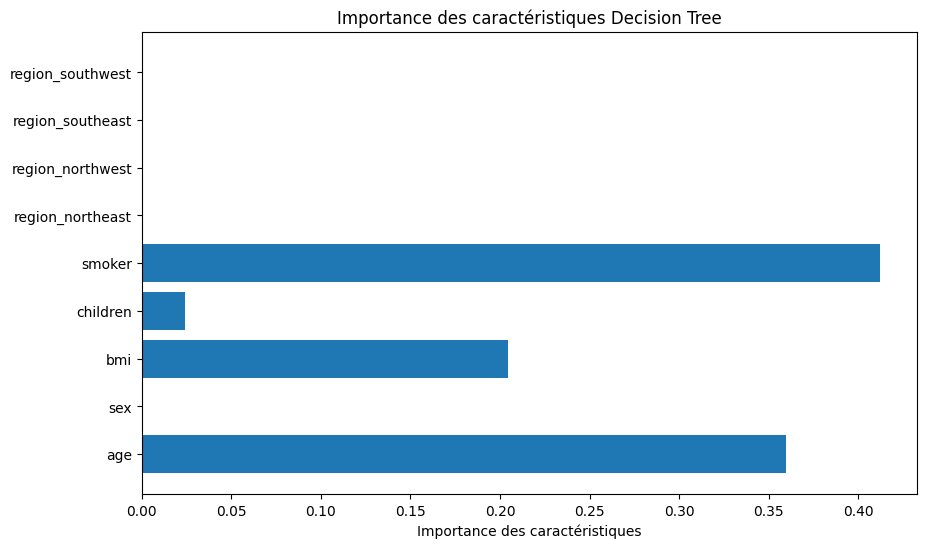

In [ ]:
importance_tree(max_depth=5, min_samples_split=5, criterion='absolute_error')

Les variables les plus importantes sont smoker, age et bmi

### Random Forest

In [ ]:
'''
Paramètres clés de Random Forest :
    - n_estimators : [10, 50, 100, 200] pour de très grands dataset, il est possible de monter jusqu'à 500
    - max_depth : limite de profondeur de l'arbre où des valeurs basses réduisent l'overfitting
    mais peut entraîner de l'underfitting ([3, 5, 10, None])
    - min_samples_split : de plus grandes valeurs nécessitent plus de données pour créer des
    splits, réduisant l'overfitting ([2, 5, 10])
'''

def random_forest_search_cv():
    '''
    Effectue des grid search et des randomized search sur des modèles Random Forest
    pour déterminer les meilleurs hyperparamètres
    '''
    model = RandomForestRegressor()
    grid_search_cv(model, param['random_forest'])
    randomized_search_cv(model, param['random_forest'])

def random_forest_cross_validation(n_estimators, max_depth, min_samples_split):
    '''
    Effectue des cross validation sur des modèles Random Forest
    '''
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    kfold_cv(model)
    s_kf_cv(model)

def random_forest(n_estimators, max_depth, min_samples_split):
    '''
    Entraînement d'un modèle Random Forest
    '''
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train_scaled, y_train_scaled)
    return model

def importance_forest(n_estimators, max_depth, min_samples_split):
    '''
    Affiche l'importance des caractéristiques avec Random Forest
    '''
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train_scaled, y_train_scaled)

    feature_names = X_train.columns
    importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.xlabel("Importance des caractéristiques")
    plt.title("Importance des caractéristiques Random Forest")
    plt.show()

In [110]:
# Grid Search et Randomized Search sur Random Forest
random_forest_search_cv()

Meilleurs paramètres: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Meilleure Cross-Validation R²: 0.8459843576349627
Meilleurs paramètres: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 3}
Meilleure Cross-Validation R²: 0.8455321756772667


In [111]:
# Cross validations sur Random Forest
random_forest_cross_validation(n_estimators=100, max_depth=5, min_samples_split=5)

k-fold cross-validation R²: 0.8526265604745031
stratified k-fold cross-validation R²: 0.8517378812962901


In [208]:
# Validation simple sur Random Forest
r2_forest, mae_forest, mse_forest, rmse_forest = performances_model(random_forest(n_estimators=100, max_depth=5, min_samples_split=5))

R² score: 0.8742739282767944
Mean Absolute Error score: 
0.04115211446022113
Mean Squared Error score: 
0.005165505835580492
Root Mean Squared Error score: 
0.07187145355132657


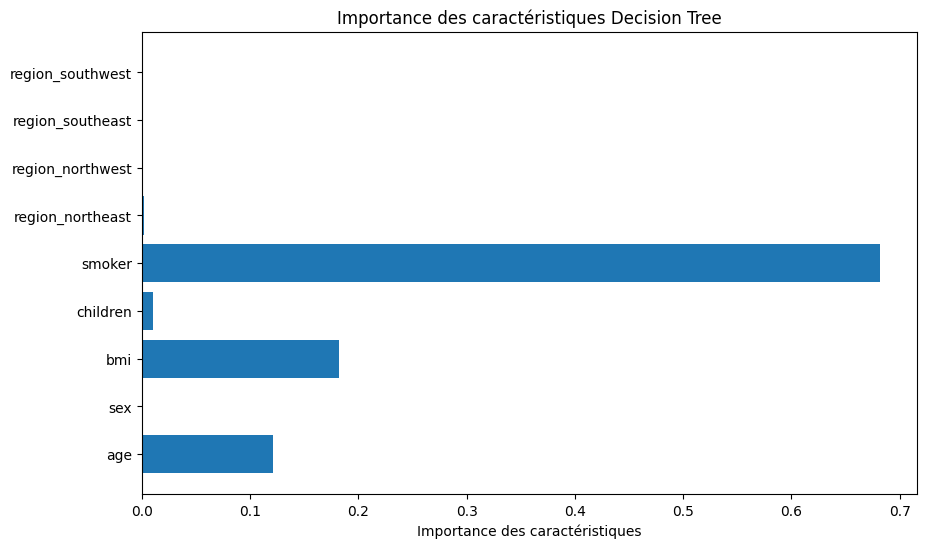

In [177]:
importance_forest(n_estimators=100, max_depth=5, min_samples_split=5)

Les variables les plus importantes sont smoker (de loin), bmi et age.

### Gradient Boosting

In [186]:
'''
Paramètres clés de Gradient Boosting :
    - n_estimators : [10, 50, 100, 200] pour de très grands dataset, il est possible de monter jusqu'à 500
    - max_depth : limite de profondeur de l'arbre où des valeurs basses réduisent l'overfitting
    mais peut entraîner de l'underfitting ([3, 5, 10, None])
    - min_samples_split : de plus grandes valeurs nécessitent plus de données pour créer des
    splits, réduisant l'overfitting ([2, 5, 10])
'''

def gradient_boosting_search_cv():
    '''
    Effectue des grid search et des randomized search sur des modèles Gradient Boosting
    pour déterminer les meilleurs hyperparamètres
    '''
    model = GradientBoostingRegressor()
    grid_search_cv(model, param['gradient_boosting'])
    randomized_search_cv(model, param['gradient_boosting'])

def gradient_boosting_cross_validation(n_estimators, max_depth, min_samples_split):
    '''
    Effectue des cross validation sur des modèles Gradient Boosting
    '''
    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    kfold_cv(model)
    s_kf_cv(model)

def gradient_boosting(n_estimators, max_depth, min_samples_split):
    '''
    Entraînement d'un modèle Gradient Boosting
    '''
    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train_scaled, y_train_scaled)
    return model

def importance_gradboost(n_estimators, max_depth, min_samples_split):
    '''
    Affiche l'importance des caractéristiques avec Gradient Boosting
    '''
    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train_scaled, y_train_scaled)

    feature_names = X_train.columns
    importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.xlabel("Importance des caractéristiques")
    plt.title("Importance des caractéristiques Gradient Boosting")
    plt.show()

In [114]:
# Grid Search et Randomized Search sur Gradient Boosting
gradient_boosting_search_cv()

Meilleurs paramètres: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}
Meilleure Cross-Validation R²: 0.8482011942236077
Meilleurs paramètres: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5}
Meilleure Cross-Validation R²: 0.8130207473346491


In [115]:
# Cross validations sur Gradient Boosting
gradient_boosting_cross_validation(n_estimators=50, max_depth=3, min_samples_split=10)

k-fold cross-validation R²: 0.8562324540911875
stratified k-fold cross-validation R²: 0.85583790172216


In [209]:
# Validation simple sur Gradient Boosting
r2_gradboost, mae_gradboost, mse_gradboost, rmse_gradboost = performances_model(gradient_boosting(n_estimators=50, max_depth=3, min_samples_split=10))

R² score: 0.8800331434666513
Mean Absolute Error score: 
0.0398217456308346
Mean Squared Error score: 
0.004928886180931098
Root Mean Squared Error score: 
0.07020602667101378


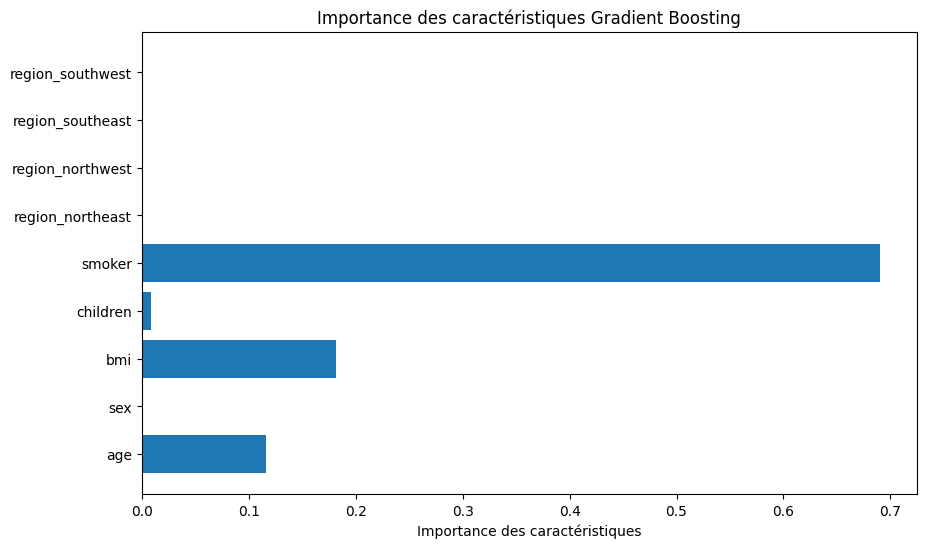

In [187]:
importance_gradboost(n_estimators=50, max_depth=3, min_samples_split=10)

Les caractéristiques les plus importantes sont smoker (de loin), bmi et age.

### Hist Gradient Boosting

In [201]:
'''
Paramètres clés de Hist Gradient Boosting :
    - max_iter :  [100, 200, 500, 1000] pour de très grands dataset, il est possible de monter jusqu'à 500
    - max_depth : limite de profondeur de l'arbre où des valeurs basses réduisent l'overfitting
    mais peut entraîner de l'underfitting ([3, 5, 10, None])
    - min_samples_leaf : valeurs plus élevées réduisent l'overfitting ([10, 20, 50, 100, 200])
'''

def hist_gradient_boosting_search_cv():
    '''
    Effectue des grid search et des randomized search sur des modèles Hist Gradient Boosting
    pour déterminer les meilleurs hyperparamètres
    '''
    model = HistGradientBoostingRegressor()
    grid_search_cv(model, param['hist_gradient_boosting'])
    randomized_search_cv(model, param['hist_gradient_boosting'])

def hist_gradient_boosting_cross_validation(max_iter, max_depth, min_samples_leaf):
    '''
    Effectue des cross validation sur des modèles Hist Gradient Boosting
    '''
    model = HistGradientBoostingRegressor(max_iter=max_iter, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    kfold_cv(model)
    s_kf_cv(model)

def hist_gradient_boosting(max_iter, max_depth, min_samples_leaf):
    '''
    Entraînement d'un modèle Hist Gradient Boosting
    '''
    model = HistGradientBoostingRegressor(max_iter=max_iter, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    model.fit(X_train_scaled, y_train_scaled)
    return model

def importance_histgradboost(max_iter, max_depth, min_samples_leaf):
    model = hist_gradient_boosting(max_iter, max_depth, min_samples_leaf)
    perm_importance = permutation_importance(model, X_test_scaled, y_test_scaled, n_repeats=10, random_state=42)

    # Print results
    for i, score in enumerate(perm_importance.importances_mean):
        print(f"Feature {i}: Importance = {score}")

In [118]:
# Grid Search et Randomized Search sur Hist Gradient Boosting
hist_gradient_boosting_search_cv()

Meilleurs paramètres: {'max_depth': 3, 'max_iter': 100, 'min_samples_leaf': 20}
Meilleure Cross-Validation R²: 0.847793748084273
Meilleurs paramètres: {'min_samples_leaf': 100, 'max_iter': 1000, 'max_depth': 3}
Meilleure Cross-Validation R²: 0.8294237220224308


In [119]:
# Cross validations sur Hist Gradient Boosting
hist_gradient_boosting_cross_validation(max_iter=100, max_depth=3, min_samples_leaf=20)

k-fold cross-validation R²: 0.8563833413465576
stratified k-fold cross-validation R²: 0.8549448339859922


In [210]:
# Validation simple sur Hist Gradient Boosting
r2_histgradboost, mae_histgradboost, mse_histgradboost, rmse_histgradboost = performances_model(hist_gradient_boosting(max_iter=100, max_depth=3, min_samples_leaf=20))

R² score: 0.8777099143604845
Mean Absolute Error score: 
0.03993159993758133
Mean Squared Error score: 
0.005024336975987472
Root Mean Squared Error score: 
0.07088255762871055


In [202]:
importance_histgradboost(max_iter=100, max_depth=3, min_samples_leaf=20)
display(X_train.columns)

Feature 0: Importance = 0.18145393707528037
Feature 1: Importance = -0.0016647308388817784
Feature 2: Importance = 0.2504434782169547
Feature 3: Importance = 0.01269987872369931
Feature 4: Importance = 1.3846481561857698
Feature 5: Importance = -0.00012660423617255612
Feature 6: Importance = 0.00019670631586329312
Feature 7: Importance = 0.00013438805340932892
Feature 8: Importance = 0.0004690635886863692


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

Les caractéristiques les plus importantes sont smoker, bmi et age.

## 4. Interprétation des résultats

In [ ]:
# Tableau de comparaison des métriques
result_table = {
    'model_id': ['KNN', 'Régression Linéaire', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Hist Gradient Boosting'],
    'R²': [r2_knn, r2_reglin, r2_svm, r2_tree, r2_forest, r2_gradboost, r2_histgradboost],
    'MAE': [mae_knn, mae_reglin, mae_svm, mae_tree, mae_forest, mae_gradboost, mae_histgradboost],
    'MSE': [mse_knn, mse_reglin, mse_svm, mse_tree, mse_forest, mse_gradboost, mse_histgradboost],
    'RMSE': [rmse_knn, rmse_reglin, rmse_svm, rmse_tree, rmse_forest, rmse_gradboost, rmse_histgradboost]
}

df_result = pd.DataFrame(result_table).set_index('model_id')

display(df_result)

,R²,MAE,MSE,RMSE
model_id,,,,
KNN,0.793490,0.056577,0.008485,0.092112
Régression Linéaire,0.783207,0.068361,0.008907,0.094377
SVM,0.852350,0.035734,0.006066,0.077886
Decision Tree,0.859845,0.031910,0.005758,0.075884
Random Forest,0.874274,0.041152,0.005166,0.071871
Gradient Boosting,0.880033,0.039822,0.004929,0.070206
Hist Gradient Boosting,0.877710,0.039932,0.005024,0.070883


In [ ]:
# Détermination des meilleurs résultats
meilleure_r2 = df_result['R²'].max()
meilleur_model_r2 = df_result[df_result['R²'] == meilleure_r2].index[0]
print(f'Le modèle {meilleur_model_r2} a la meilleure R² : {meilleure_r2}')

meilleure_mae = df_result['MAE'].min()
meilleur_model_mae = df_result[df_result['MAE'] == meilleure_mae].index[0]
print(f'Le modèle {meilleur_model_mae} a la meilleure MAE : {meilleure_mae}')

meilleure_mse = df_result['MSE'].min()
meilleur_model_mse = df_result[df_result['MSE'] == meilleure_mse].index[0]
print(f'Le modèle {meilleur_model_mse} a la meilleure MSE : {meilleure_mse}')

meilleure_rmse = df_result['RMSE'].min()
meilleur_model_rmse = df_result[df_result['RMSE'] == meilleure_rmse].index[0]
print(f'Le modèle {meilleur_model_rmse} a la meilleure RMSE : {meilleure_rmse}')

Le modèle Gradient Boosting a la meilleure R² : 0.8800331434666513
Le modèle Decision Tree a la meilleure MAE : 0.03191035051839758
Le modèle Gradient Boosting a la meilleure MSE : 0.004928886180931098
Le modèle Gradient Boosting a la meilleure RMSE : 0.07020602667101378


Le modèle le plus performant dans le contexte actuel est le Gradient Boosting.

In [214]:
# Comparaison des métriques de Gradient Boosting
difference_mse_mae = mae_gradboost - mse_gradboost
difference_mse_r2 = r2_gradboost - mse_gradboost
difference_mae_r2 = r2_gradboost - mae_gradboost

print(f"Différence entre MSE et MAE (plus le score est proche de 0, mieux c'est) : {difference_mse_mae}")
print(f"Différence entre MSE et R² (plus le score est proche de 1, mieux c'est) : {difference_mse_r2}")
print(f"Différence entre MAE et R² (plus le score est proche de 1, mieux c'est) : {difference_mae_r2}")

Différence entre MSE et MAE (plus le score est proche de 0, mieux c'est) : 0.0348928594499035
Différence entre MSE et R² (plus le score est proche de 1, mieux c'est) : 0.8751042572857202
Différence entre MAE et R² (plus le score est proche de 1, mieux c'est) : 0.8402113978358167


Peu d'erreurs importantes sur les prédictions avec Gradient Boosting.

Gradien Boosting est donc le modèle le plus performant et le plus robuste.

## 5. Sauvegarde et utilisation du modèle retenu

### Sauvegarde du modèle

In [20]:
import joblib

model = GradientBoostingRegressor(n_estimators=50, max_depth=3, min_samples_split=10)
model.fit(X_train, y_train)

joblib.dump(model, 'gradient_boosting_model.joblib')

c:\Users\tiger\OneDrive\Documents\GitHub\medical_expenses_manager\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


['gradient_boosting_model.joblib']

### Chargement et utilisation du modèle

In [21]:
# Chargement du modèle
loaded_model = joblib.load('gradient_boosting_model.joblib')

In [27]:
# Nouvelle ligne de données à tester
data = {
    'age': [34],
    'sex': ['male'],
    'bmi': [18.1],
    'children': [3],
    'smoker': ['no'],
    'region': ['northwest']
}

In [28]:
# Conversion du dictionnaire en DataFrame
df = pd.DataFrame(data)

In [29]:
# Encode et mise à l'échelle des nouvelles données
binary_encoder(df=df, colonne='sex', choix_true='female', choix_false='male')
binary_encoder(df=df, colonne='smoker', choix_true='yes', choix_false='no')

df['region_northeast'] = 0
df['region_northwest'] = 0
df['region_southeast'] = 0
df['region_southwest'] = 0

if df['region'][0] == 'northwest':
    df.loc[0, "region_northwest"] = 1
elif df['region'][0] == 'northeast':
    df.loc[0, "region_northeast"] = 1
elif df['region'][0] == 'southwest':
    df.loc[0, "region_southwest"] = 1
elif df['region'][0] == 'southeast':
    df.loc[0, "region_southeast"] = 1

df.drop(labels='region', axis=1, inplace=True)

scaler = MinMaxScaler()
scaler.fit(X_train)
df_scaled = scaler.transform(df)

In [30]:
# Prédiction
y_pred = loaded_model.predict(df_scaled)

print(f"Prédiction de expenses : {y_pred}")

Prédiction de expenses : [3801.78192391]


c:\Users\tiger\OneDrive\Documents\GitHub\medical_expenses_manager\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


- La prédiction est cohérente avec les données d'entraînement.
- En jouant sur le paramètre le plus influent (smoker) on peut constater une nette différence du expenses prédit entre 'yes' et 'no'.

In [2]:
import sys
import sklearn

print(sys.version)
print(sklearn.__version__)


3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
1.6.1
